In [8]:
#change  datasetpath to where dataset is stored or create a Dataset folder in directory you run this file
import os
dataset_path  = os.getcwd() + "/Dataset"
stopwords_path = dataset_path + "/stop_words.txt"
pos_words_path = dataset_path + "/positive_words.txt"
neg_words_path = dataset_path + "/negative_words.txt"
train_path = dataset_path + "/train"
pos_train_path = train_path + "/pos"
neg_train_path = train_path + "/neg"
test_path = dataset_path + "/test"
pos_test_path = test_path + "/pos"
neg_test_path = test_path + "/neg"

import math
import numpy as np
import glob
import re

def read_file(filepath):
    if '.txt' in filepath:
        with open(filepath,'r',encoding='utf-8') as f:
            file_content = f.read()
    return file_content
def read_words(filepath):
    if '.txt' in filepath:
        with open(filepath,'r') as f:
            file_content = f.readlines()
    return file_content
def load_words(word_filepath):
    word_list = read_words(word_filepath)
    words = []
    for line in word_list:
        words.append(line.strip())
    return words
def parse_filenames(filenames):
    ratings = []
    i = 1
    for filename in filenames:
        split = re.split("\W+",filename)
        unparsed_rating = split[4]
        rating = re.split("_",unparsed_rating)
        ratings.append(rating)
    return ratings
        
def read_reviews(path):
    new_path = path + "/*.*"
    filenames = glob.glob(new_path)
    reviews = []
    i = 0 
    for filename in filenames:
        review  = read_file(filename)
        reviews.append(review)
        i = i + 1
    return reviews
def load_test_data():
    import datetime
    start_time = datetime.datetime.now()
    print("starting preprocessing")
    processed_reviews = preprocess_reviews(pos_test_path,neg_test_path)
    finish_time = datetime.datetime.now() - start_time

    print("finished preprocessing in",finish_time)
    neg_reviews = processed_reviews[0]
    pos_reviews = processed_reviews[1]
    start_time = datetime.datetime.now()
    print("starting feature extraction")
    extractions = feature_extraction(neg_reviews,pos_reviews)
    finish_time = datetime.datetime.now() - start_time
    print("finished feature extraction in",finish_time)
    X = np.array(extractions[0])
    y_true = np.array(extractions[1])
    return X,y_true
def load_train_data():
    import datetime
    start_time = datetime.datetime.now()
    print("starting preprocessing")
    processed_reviews = preprocess_reviews(pos_train_path,neg_train_path)
    finish_time = datetime.datetime.now() - start_time

    print("finished preprocessing in",finish_time)
    neg_reviews = processed_reviews[0]
    pos_reviews = processed_reviews[1]
    start_time = datetime.datetime.now()
    print("starting feature extraction")
    extractions = feature_extraction(neg_reviews,pos_reviews)
    finish_time = datetime.datetime.now() - start_time
    print("finished feature extraction in",finish_time)
    X = np.array(extractions[0])
    y_true = np.array(extractions[1])
    return X,y_true

def remove_stopwords_from_reviews(reviews,stopwords):
    stopless_review_list = []
    for review in reviews:
        split_review = [word.lower() for word in re.split("\W+",review) if word.lower() not in stopwords]
        empty_char = ' '
        stopless_review = empty_char.join(split_review)
        stopless_review_list.append(stopless_review)
    return stopless_review_list
def preprocess_reviews(pos_path,neg_path):
    pos_reviews = read_reviews(pos_path)
    neg_reviews = read_reviews(neg_path)
    stopwords = load_words(stopwords_path)
    stopless_pos_reviews = remove_stopwords_from_reviews(pos_reviews,stopwords)
    stopless_neg_reviews = remove_stopwords_from_reviews(neg_reviews,stopwords)
    return [stopless_neg_reviews,stopless_pos_reviews]

def count_positive_words(review):
    count = 0 
    words_in_review = review.split()
    pos_words = load_words(pos_words_path)
    pos_words_dict = create_dictionary(pos_words)
    for word in words_in_review:
        present = 1
        present = pos_words_dict.get(word,0)
        if present !=0:
            count = count + 1
    return count
def count_negative_words(review):
    neg_words = load_words(neg_words_path)
    count = 0 
    words_in_review = review.split()
    neg_words_dict = create_dictionary(neg_words)
    for word in words_in_review:
        present = 1
        present = neg_words_dict.get(word,0)
        if present != 0:
            count = count + 1
    return count
def create_dictionary(words):
    dictionary = {}
    for word in words:
        dictionary[word] = 1
    return dictionary
def create_feature_vector(reviews):
    all_reviews_feature_vector = []
    x_0 = 1 
    for review in reviews:
        x_1 = count_positive_words(review)
        x_2 = count_negative_words(review)
        feature_vector = [ x_0,x_1,x_2]
        all_reviews_feature_vector.append(feature_vector)
    return all_reviews_feature_vector
def create_label_vector(label,length):
    label = [label for i in range(length) ]
    return label


def feature_extraction(neg_reviews,pos_reviews):
    pos_feature_vec = create_feature_vector(pos_reviews)
    neg_feature_vec = create_feature_vector(neg_reviews)
    pos_labels = create_label_vector(1,len(pos_feature_vec))
    neg_labels  = create_label_vector(0,len(neg_feature_vec))
    training_feature_vector = pos_feature_vec + neg_feature_vec
    training_feature_vector = np.array(training_feature_vector) 
    training_labels = pos_labels + neg_labels
    training_labels = np.array(training_labels) 
    return [training_feature_vector,training_labels]
    
    
  





In [9]:
def sigmoid(x):
    one = np.ones(x.shape)
    h = (one / (one + np.exp(-x)))
    return h
def cross_entropy(y_pred,y):
    import math
    one = np.ones(y_pred.shape)
    epsilon = math.exp(-14)
    ans =  y*np.log(y_pred + epsilon) + (one-y)*np.log(one-y_pred + epsilon)
    return ans
def h(X,thetas):
    h_x = np.dot(thetas,X.transpose())
    s = sigmoid(h_x) 
    return s
    
def compute_cost(y_pred,y):
    from sklearn.metrics import log_loss
    #J(theta) = (-1/m) * summation (cross_entropy)
#     vectorized_cross_entropy = np.vectorize(cross_entropy)
    cross_entropy_vector = cross_entropy(y_pred,y)
    m = y_pred.shape[0]
    loss = np.sum(cross_entropy_vector)
    loss = -loss/m
    return loss
def gradientDescent(X, Y, alpha, n_epoch):
    m = Y.size  # number of training examples
    J = list()  # list to store cost
    t = []
    thetas = np.array([0,0,0])
    deriv_theta =[0,0,0]
    for epoch in range(n_epoch):
        y_pred = h(X,thetas)
        diff = np.subtract(y_pred,Y)
        Xt = X.transpose()
        for j in range(3):
            error = []
            for i in range(m):
                feature_j = Xt[j][i]
                error.append(diff[i] * feature_j)
            error = np.array(error)
            sum_error = np.sum(error)
            deriv_theta[j] = (1/m) * sum_error
        deriv_theta = np.array(deriv_theta)
        thetas = thetas - deriv_theta*alpha
        t.append(thetas)
        h_x = h(X,thetas)
        J.append(compute_cost(h_x,Y))
    J = np.array(J)
    t = np.array(t)
    return J,t

In [10]:
import matplotlib.pyplot as plt



def train_logistic_regressor_part1():
    import datetime
    initial_time = datetime.datetime.now()
    print("starting training")
    X,y_true = load_train_data()
    n_epoch = 300
    alpha = 0.01
    start_time = datetime.datetime.now()
    print("starting gradient descent")
    J,t = gradientDescent(X,y_true,alpha,n_epoch)

    plt.plot(J)
    plt.title("Cost vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.show()
    finish_time = datetime.datetime.now() - start_time
    print("finished gradient descent in",finish_time)
    finish_time= datetime.datetime.now() - initial_time
    min_J = np.argmin(J)
    thetas = t[min_J]
    print("finished training in",finish_time)
    return X,thetas
def predict_logistic_regressor_part1(thetas):
    import datetime
    start_time=datetime.datetime.now()
    print("starting predictions")
    X,y_true = load_test_data()
    y_prob = h(X,thetas)
    y_pred = y_prob > 0.5
    y_pred = y_pred.astype(int)
    finish_time = datetime.datetime.now() - start_time
    print("finished predictions in",finish_time)
    return y_pred,y_true
def compute_accuracy(predictions,ground_truth):
    total = len(predictions) 
    l = len(predictions)
    match = 0
    for i in range(l):
        if predictions[i] == ground_truth[i]:
            match = match + 1
    accuracy = match / total
    return accuracy
def compute_interclass_false_positives(predictions,ground_truth):
    l = len(predictions)
    total = l
    neg_false_pos = 0
    pos_false_pos =  0
    

    for i in range(l):
        if predictions[i] == 0 and ground_truth[i] == 1:
            neg_false_pos = neg_false_pos + 1
        if predictions[i] == 1 and ground_truth[i]  == 0:
            pos_false_pos =  pos_false_pos + 1
    all_fps = [pos_false_pos,neg_false_pos]
    return all_fps
def compute_true_positives(predictions,ground_truth):
    l = len(predictions)
    total = l
    neg_match = 0
    pos_match =  0 
    for i in range(l):
        if predictions[i] == ground_truth[i] and ground_truth[i] == 0:
            neg_match = neg_match + 1
        if predictions[i] == ground_truth[i] and ground_truth[i] == 1:
            pos_match = pos_match + 1
    all_tps = [neg_match,pos_match ]
    return all_tps
def compute_confusion_matrix(predictions,ground_truth):
    tp_neg,tp_pos = compute_true_positives(predictions,ground_truth)
    all_fps = compute_interclass_false_positives(predictions,ground_truth)
    matrix = [[2,3],[5,6]]
    matrix[0][0] = tp_neg
    matrix[0][1] = all_fps[1]
    matrix[1][0] =all_fps[0]
    matrix[1][1] =tp_pos
    return matrix




executing part 1
starting training
starting preprocessing
finished preprocessing in 0:03:49.869121
starting feature extraction
finished feature extraction in 0:02:05.955906
starting gradient descent


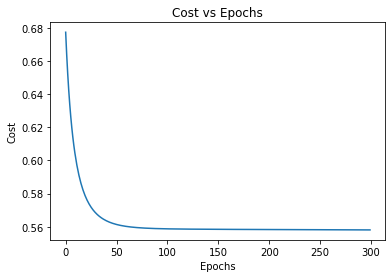

finished gradient descent in 0:00:44.471922
finished training in 0:06:40.317146
starting predictions
starting preprocessing
finished preprocessing in 0:04:08.262979
starting feature extraction
finished feature extraction in 0:02:20.200285
finished predictions in 0:06:28.473206
testing accuracy is  0.7342
confusion matrix for test set is
                  Ground_Negative,Ground_Positive
Predicted_Negative 9037             3182 
Predicted_Positive 3463             9318
finished part 1 in 0:13:08.990254


In [5]:
def execute_part1():
    import datetime
    print("executing part 1")
    initial_time = datetime.datetime.now()
    #get trained thetas and processed training X
    X,thetas = train_logistic_regressor_part1()
    y_prob = h(X,thetas)
    #setting a decision threshold
    y_pred_train = y_prob > 0.5
    y_pred_train = y_pred_train.astype(int)
    #make predictions usings trained thetas
    y_pred_test,y_true_test = predict_logistic_regressor_part1(thetas)
    test_acc = compute_accuracy(y_pred_test,y_true_test)
    confusion_matrix = compute_confusion_matrix(y_pred_test,y_true_test)
    print("testing accuracy is ",test_acc)
    print("confusion matrix for test set is\n                  Ground_Negative,Ground_Positive\nPredicted_Negative",str(np.array(confusion_matrix)[0][0]) + "             " + str(np.array(confusion_matrix)[0][1]),"\nPredicted_Positive",str(np.array(confusion_matrix)[1][0]) + "             " + str(np.array(confusion_matrix)[1][1]))
    finish_time = datetime.datetime.now() - initial_time
    print("finished part 1 in",finish_time)
    return y_pred_test,y_true_test
yp,yt = execute_part1()


In [6]:
# You can run this cell to cross check my accuracies and conf matrix against scikit-learns's
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
cm = confusion_matrix(yp,yt)
a = accuracy_score(yp,yt)
print(cm)
print(a)

[[9037 3182]
 [3463 9318]]
0.7342


In [11]:
from sklearn.linear_model import LogisticRegression
def execute_part2():
    import datetime
    print("executing part 2")
    initial_time = datetime.datetime.now()
    train_X,train_Y = load_train_data()
    test_X,test_Y = load_test_data()
    clf = LogisticRegression(penalty= 'none').fit(train_X,train_Y)
    test_Y_pred = clf.predict(test_X)
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    print("testing acc is",accuracy_score(test_Y_pred,test_Y))
    print("confusion matrix is\n",confusion_matrix(test_Y_pred,test_Y))
    finish_time = datetime.datetime.now() - initial_time
    print("finished part 2 in",finish_time)
    
execute_part2()

executing part 2
starting preprocessing
finished preprocessing in 0:00:39.333188
starting feature extraction
finished feature extraction in 0:02:49.312790
starting preprocessing
finished preprocessing in 0:02:39.934086
starting feature extraction
finished feature extraction in 0:02:57.178251
testing acc is 0.73056
confusion matrix is
 [[9226 3462]
 [3274 9038]]
finished part 2 in 0:09:06.030270
